Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified:\
DSI

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from deep_translator import GoogleTranslator

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [126]:
kernel = pd.read_csv("../data/import genius/kernel_10000.csv", parse_dates=["EXPORT DATE"])

print("Columns: ", kernel.dtypes)

# All custom office values are NaN
print("Custom office values: ", kernel["CUSTOMS VALUE"].dropna().values)

# We still have to get data from 2011 to 2021
print("Min year: ",kernel["EXPORT DATE"].dt.year.min(skipna=True))
print("Max year: ", kernel["EXPORT DATE"].dt.year.max(skipna=True))

kernel.head()



Columns:  PRODUCT                                     object
HS CODE                                      int64
CONSIGNEE                                   object
CONSIGNEE ADDRESS                          float64
SHIPPER                                     object
SHIPPER ADDRESS                            float64
EXPORT DATE                         datetime64[ns]
QUANTITY                                   float64
WEIGHT (KG)                                float64
INVOICE PRICE (UAH)                        float64
TOTAL INVOICE VALUE (USD)                  float64
INVOICE PRICE IN KILOGRAMS (USD)           float64
ITEM UNIT                                  float64
ITEM NUMBER                                float64
CUSTOMS VALUE                              float64
CUSTOMS OFFICE CODE                          int64
COUNTRY OF ORIGIN                          float64
DESTINATION COUNTRY                         object
PLACE OF DELIVERY                          float64
DELIVERY TERMS       

,PRODUCT,HS CODE,CONSIGNEE,CONSIGNEE ADDRESS,SHIPPER,SHIPPER ADDRESS,EXPORT DATE,QUANTITY,WEIGHT (KG),INVOICE PRICE (UAH),...,CUSTOMS VALUE,CUSTOMS OFFICE CODE,COUNTRY OF ORIGIN,DESTINATION COUNTRY,PLACE OF DELIVERY,DELIVERY TERMS,DECLARATION NO.,CURRENCY RATIO,SENDER CODE,BANK NAME
0,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4138,NaN,31454383,NaN
1,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23930.0000,753795.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4141,NaN,31454383,NaN
2,СОЛІ ТА ГІДРОКСИДИ АМОНІЮ ЧЕТВЕРТИННІ; ЛЕЦИТИН...,2923200000,NATEEO SRL VIA DELL INNOVAZIONE N 1 36043 CAMI...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23700.0000,4408200.0000,...,NaN,0,NaN,ІТАЛІЯ,NaN,DAP IT CAMISANO VICENTINO V,4147,NaN,31454383,NaN
3,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24380.0000,1025550.0000,...,NaN,0,NaN,СЕНЕГАЛ,NaN,FAS RO CONSTANTA,4148,NaN,31454383,NaN
4,"ОЛІЇ СОНЯШНИКОВА, САФЛОРОВА АБО БАВОВНЯНА ТА Ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23950.0000,754425.0000,...,NaN,0,NaN,ОМАН,NaN,FCA UA ПОЛТАВА,4118,NaN,31454383,NaN


In [127]:
# EXPORTS TIME SERIES

# We first have to translate the "PRODUCT" column with the deep_translator API
# PENDING: remove .head to apply translation to the whole "PRODUCT" column. I started translating everything and took around 15 mins and was still translating... :/

kernel_c = kernel.copy()
kernel_c["product_en"] = kernel_c.head()["PRODUCT"].apply(lambda x: GoogleTranslator(source='auto', target='en').translate(x))
kernel_c.head()["product_en"]

0    SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...
1    SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...
2    QUATERNARY AMMONIUM SALTS AND HYDROXIDES; LECI...
3    SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...
4    SUNFLOWER, SAFFLOWER OR COTTON OILS AND THEIR ...
Name: product_en, dtype: object

Text(0, 0.5, 'Products exported (tons)')

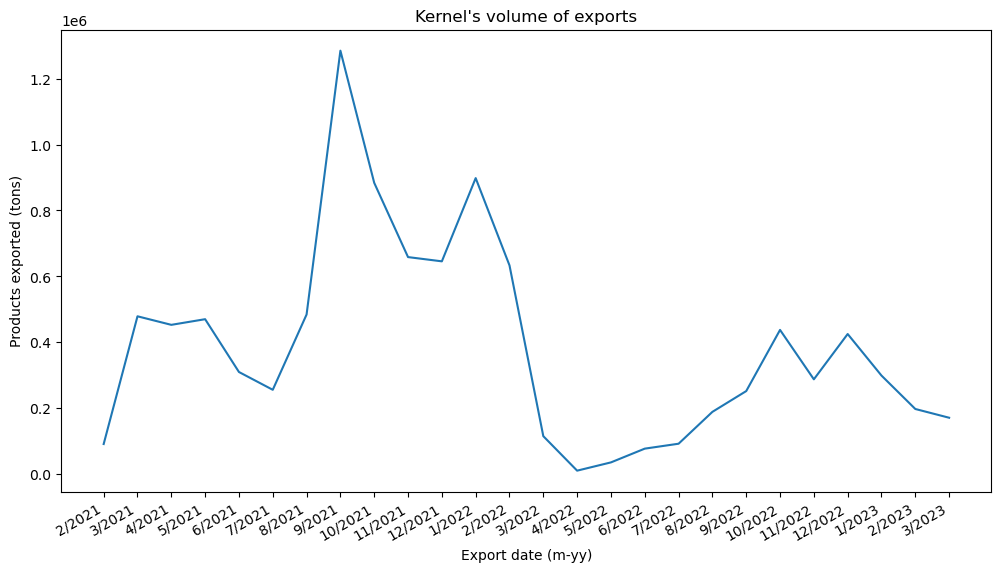

In [134]:
kernel_c["year"] = kernel_c["EXPORT DATE"].dt.year
kernel_c["month"] = kernel_c["EXPORT DATE"].dt.month
kernel_c["weight_ton"] = kernel_c["WEIGHT (KG)"] / 1000

kernel_g = kernel_c[["year", "month", "weight_ton"]].groupby(["year", "month"])
kernel_g = kernel_g.sum().reset_index()
kernel_g.sort_values(by=["year", "month"], ascending=False)

kernel_g["date"] = kernel_g["month"].astype(str) + "/" + kernel_g["year"].astype(str)
kernel_g

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(kernel_g["date"] , kernel_g["weight_ton"])
# ax.ticklabel_format(useOffset=False, style='plain')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.title("Kernel's volume of exports")
plt.xlabel("Export date (m-yy)")
plt.ylabel("Products exported (tons)")
